In [1]:
import os
from dotenv import load_dotenv
from typing import Dict, List, Any, Optional, Annotated, Union, Literal
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI
from langchain_community.utilities.sql_database import SQLDatabase
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_openai import OpenAIEmbeddings
from langchain_core.tools import tool
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage, AIMessage, ToolMessage
from langchain_core.runnables import RunnablePassthrough
from langgraph.graph import MessagesState

from langgraph.prebuilt import tools_condition, ToolNode

from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode

from IPython.display import Image, display

In [2]:
load_dotenv()

True

In [3]:
db = SQLDatabase.from_uri("sqlite:///../sql-support-bot/chinook.db")
print(db.get_usable_table_names())

['albums', 'artists', 'customers', 'employees', 'genres', 'invoice_items', 'invoices', 'media_types', 'playlist_track', 'playlists', 'tracks']


In [4]:
os.environ["LANGCHAIN_PROJECT"] = "music-store-support-demo-prep"

## Set up state

In [5]:
class MusicStoreChatbotState(MessagesState):
    customer_id: Optional[int]
    current_mode: Literal["router", "account", "music"]

In [6]:
account_agent_model = ChatOpenAI(temperature=0, model_name="gpt-4o-mini")

## Helper Functions

In [7]:
def get_last_human_message(messages: List[BaseMessage]) -> Optional[HumanMessage]:
    """Extract the last human message from the conversation history."""
    for message in reversed(messages):
        if isinstance(message, HumanMessage):
            return message
    return None


def print_conversation(state):
    print("\n" + "="*50)
    print("CONVERSATION")
    print("="*50)
    
    for message in state["messages"]:
        if isinstance(message, HumanMessage):
            print(f"\n👤 USER: {message.content}")
        
        elif isinstance(message, AIMessage):
            # Skip empty AI messages (they're usually just tool calls)
            if message.content:
                print(f"\n🤖 ASSISTANT: {message.content}")
            # Optionally print tool calls if you want to see them
            if hasattr(message, "tool_calls") and message.tool_calls:
                for tool_call in message.tool_calls:
                    print(f"\n🔧 TOOL CALL: {tool_call['name']}({tool_call['args']})")
        
        elif isinstance(message, ToolMessage):
            # Usually you don't need to show these raw tool responses to users
            # But for debugging they can be helpful
            print(f"\n🔧 TOOL RESPONSE ({message.name}): {message.content[:100]}..." if len(message.content) > 100 else message.content)
    
    print("\n" + "="*50)

## Graph definition

### Node: Route based on Customer ID

In [8]:
def is_customer_id_known(state: MusicStoreChatbotState):
    """Routing based on Customer ID"""
    print("T" * 50)
    print("is_customer_id_known")
    print("T" * 50)
    return state

### Tools

In [9]:
@tool
def get_customer_info(customer_id: int):
    """Look up customer info given their ID. Requires customer authentication."""
    return db.run(f"SELECT * FROM customers WHERE CustomerId = {customer_id};")

@tool
def update_customer_info(customer_id: int, field: str, value: str):
    """
    Update a customer's information.
    - customer_id: The ID of the customer to update
    - field: The field to update (FirstName, LastName, Company, Address, City, State, Country, PostalCode, Phone, Email)
    - value: The new value for the field
    """
    print("T" * 50)
    print(f"update_customer_info invoked witn {customer_id}, {field}, {value}")
    print("T" * 50)
    allowed_fields = ["FirstName", "LastName", "Company", "Address", "City", 
                       "State", "Country", "PostalCode", "Phone", "Email"]

    if field not in allowed_fields:
        print(f"Invalid field: {field} !!!!!!!!")
        return f"Error: Cannot update field '{field}'. Allowed fields are: {', '.join(allowed_fields)}"

    # Verify customer exists first
    customer = db.run(f"SELECT * FROM customers WHERE CustomerId = {customer_id};")
    if not customer:
        return f"Error: No customer found with ID {customer_id}"

    try:
        # Sanitize the value to prevent SQL injection
        sanitized_value = value.replace("'", "''")  # Double up single quotes for SQL safety
        
        # Execute the actual update query
        update_query = f"UPDATE customers SET {field} = '{sanitized_value}' WHERE CustomerId = {customer_id};"
        db.run(update_query)
        
        # Verify the update was successful
        updated_customer = db.run(f"SELECT {field} FROM customers WHERE CustomerId = {customer_id};")
        if updated_customer and updated_customer[0][field] == value:
            return f"Successfully updated {field} to '{value}' for customer {customer_id}"
        else:
            return f"Update attempted but verification failed. Please check the database."
    
    except Exception as e:
        print(f"Database error: {str(e)}")
        return f"Error updating database: {str(e)}"


get_tool_names = ["get_customer_info"]
get_tools = [get_customer_info]
update_tool_names = ["update_customer_info"]
update_tools = [update_customer_info]

In [10]:
account_agent_model_with_tools = account_agent_model.bind_tools(tools=[get_customer_info, update_customer_info])

### Node: Process Account Query

In [11]:
account_system_message = """You are a customer account specialist at a music store.
You can help customers:
1. Retrieve their account information
2. Update their profile details

Your response should be concise and in natural language. 

If a user is not found for the provided ID, please inform the user that the ID is invalid
"""

def handle_account_query(state: MusicStoreChatbotState):
    """Handle account-related queries"""
    assert state["customer_id"] is not None
    print("T" * 50)
    print("handle_account_query")
    print("T" * 50)

    # Build messages for the account agent
    messages = [SystemMessage(content=account_system_message)]
    # Add some conversation context
    context_messages = state["messages"][-5:] if len(state["messages"]) > 5 else state["messages"]
    messages.extend(context_messages)

    # Add customer context
    customer_id = state["customer_id"]
    messages.append(SystemMessage(content=f"Current authenticated customer ID: {customer_id}"))

    # Let the agent determine what to do next
    response = account_agent_model_with_tools.invoke(messages)

    print(f"handle_account_query response = {response}")

    return {
        "messages": state["messages"] + [response]
    }


def handle_account_query_route_condition(state: MusicStoreChatbotState) -> str:
    last_message = state["messages"][-1]
    destination = END

    # Check if the last message has tool calls
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        # Get the name of the called tool
        tool_name = last_message.tool_calls[0]["name"]
        
        # Route to the appropriate tool node
        if tool_name in get_tool_names:
            destination = "lookup_tools"
        elif tool_name in update_tool_names:
            destination = "update_tools"
    
    print("~" * 50)
    print(f"Destination = {destination}")
    print("~" * 50)
    return destination

### Update Customer ID if in query (TODO: 1. Verify, 2. Prompt user)

In [12]:
customer_id_prompt = """Your task is to help determine the Customer ID of the user based on their presented chat history. 
If you are able to determine their Customer ID, return just the ID. If the ID cannot be inferred, return UNKNOWN."""

def get_customer_id(state: MusicStoreChatbotState):
    """Fetch the custimer ID if it is part of the query"""
    print("T" * 50)
    print("get_customer_id")
    print("T" * 50)
    assert state["customer_id"] is None

    messages = [SystemMessage(content=customer_id_prompt)]
    # Add some conversation context
    context_messages = state["messages"][-5:] if len(state["messages"]) > 5 else state["messages"]
    messages.extend(context_messages)

    # Let the agent determine what to do next
    response = account_agent_model.invoke(messages)
    print(f"Raw router response = {response.content}")

    # Update the state with the correct department
    content = response.content.lower()
    if content.isdigit():
        return {"customer_id": int(content)}
    else:
        return state

In [13]:
def customer_id_set_route_condition(state: MusicStoreChatbotState) -> bool:
    """Return the routing condition based on the current state"""
    customer_id_is_known = state["customer_id"] is not None
    print("~" * 50)
    print(f"Destination = {customer_id_is_known}")
    print("~" * 50)
    return state["customer_id"] is not None

def customer_id_valid_route_condition(state: MusicStoreChatbotState) -> Literal["valid", "invalid"]:
    """Return the routing condition based on the current state"""
    # This is just to demonstrate more complex logic can also reside in the route condition.
    # This logic could also be moved up to `get_customer_id`.
    if state["customer_id"] is None:
        return "invalid"
    customer = db.run(f"SELECT * FROM customers WHERE CustomerId = {state["customer_id"]};")
    if not customer:
        return "invalid"
    return "valid"

account_agent_graph_builder = StateGraph(MusicStoreChatbotState)
account_agent_graph_builder.add_node("is_customer_id_known", is_customer_id_known)
account_agent_graph_builder.add_node("handle_account_query", handle_account_query)
account_agent_graph_builder.add_node("get_customer_id", get_customer_id)
account_agent_graph_builder.add_node("lookup_tools", ToolNode(get_tools))
account_agent_graph_builder.add_node("update_tools", ToolNode(update_tools))

# Add the starting edge
account_agent_graph_builder.add_edge(START, "is_customer_id_known")
account_agent_graph_builder.add_edge("lookup_tools", "handle_account_query")
account_agent_graph_builder.add_edge("update_tools", "handle_account_query")

account_agent_graph_builder.add_conditional_edges(
    "is_customer_id_known",  # Source node
    customer_id_set_route_condition,  # Function that returns the condition value
    {
        True: "handle_account_query",
        False: "get_customer_id",
    }
)

account_agent_graph_builder.add_conditional_edges(
    "handle_account_query",  # Source node
    handle_account_query_route_condition,  # Function that returns the condition value
    {
        "update_tools": "update_tools",
        "lookup_tools": "lookup_tools",
        END: END
    }
)

account_agent_graph_builder.add_conditional_edges(
    "get_customer_id",  # Source node
    customer_id_valid_route_condition,  # Function that returns the condition value
    {
        "valid": "is_customer_id_known",
        "invalid": END,
    }
)

memory = MemorySaver()
# Can hard-code interruptions  using `builder.compile(interrupt_before=["tools"], checkpointer=memory)`
account_agent_graph = account_agent_graph_builder.compile(interrupt_before=["update_tools"], checkpointer=memory)

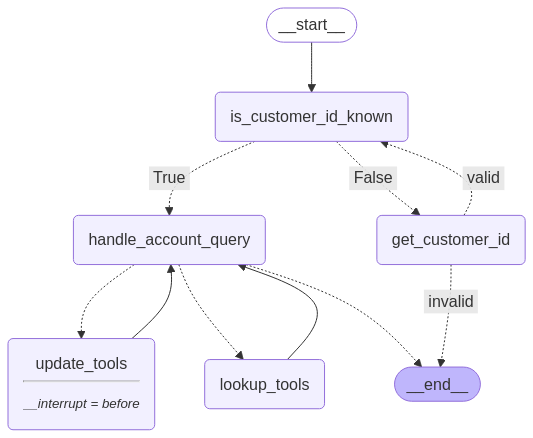

In [14]:
display(Image(account_agent_graph.get_graph().draw_mermaid_png()))

### Test

In [15]:
# Define a thread config dictionary
thread_config = {"configurable": {"thread_id": "22"}}

# Then use it in your invoke call
response = account_agent_graph.invoke(
    {"messages": [HumanMessage(content="Hey, my customer ID is 2. Please show me all my information")], 
     "current_mode": "router", 
     "customer_id": None}, 
    thread_config
)

print_conversation(response)

TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
is_customer_id_known
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Destination = False
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
get_customer_id
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Raw router response = 2
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
is_customer_id_known
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Destination = True
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
handle_account_query
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
handle_account_query response = content='' additional_kwargs={'tool_calls': [{'id': 'call_u4GTmdwQzqFsisDfgobUXSzT', 'function': {'arguments': '{"customer_id":2}', 'name': 'get_customer_info'}, 'type': 'function'}], 'refusal': None} response_meta

In [16]:
# Define a thread config dictionary
thread_config = {"configurable": {"thread_id": "1"}}

# Then use it in your invoke call
response = account_agent_graph.invoke(
    {"messages": [HumanMessage(content="Hey. recommend music by Amy Winehouse")], 
     "current_mode": "router", 
     "customer_id": None}, 
    thread_config
)

print_conversation(response)

TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
is_customer_id_known
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Destination = False
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
get_customer_id
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Raw router response = UNKNOWN

CONVERSATION

👤 USER: Hey. recommend music by Amy Winehouse



In [17]:
# Define a thread config dictionary
thread_config = {"configurable": {"thread_id": "1"}}

# Then use it in your invoke call
response = account_agent_graph.invoke(
    {"messages": [HumanMessage(content="Hey, my customer ID is 2. Please update my email to a@b.com")], 
     "current_mode": "router", 
     "customer_id": None}, 
    thread_config
)

print_conversation(response)

TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
is_customer_id_known
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Destination = False
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
get_customer_id
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Raw router response = 2
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
is_customer_id_known
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Destination = True
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
handle_account_query
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
handle_account_query response = content='' additional_kwargs={'tool_calls': [{'id': 'call_cQ7zZSiKuZ0qBVp8SGj5UanJ', 'function': {'arguments': '{"customer_id":2,"field":"Email","value":"a@b.com"}', 'name': 'update_customer_info'}, 'type': 'functi

In [18]:
# Input
initial_input = {
    "messages": [HumanMessage(content="Hey, my customer ID is 2. Please update my email to a@b.com")], 
    "current_mode": "router", 
    "customer_id": None
}

# Thread
thread = {"configurable": {"thread_id": "12"}}

# Run the graph until the first interruption
for event in account_agent_graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

# Get user feedback
user_approval = input("Do you want to call the tool? (yes/no): ")

# Check approval
if user_approval.lower() == "yes":
    
    # If approved, continue the graph execution
    for event in account_agent_graph.stream(None, thread, stream_mode="values"):
        event['messages'][-1].pretty_print()
        
else:
    print("Operation cancelled by user.")

get_customer_info({"customer_id" : 2})

================================ Human Message =================================

Hey, my customer ID is 2. Please update my email to a@b.com
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
is_customer_id_known
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Destination = False
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
================================ Human Message =================================

Hey, my customer ID is 2. Please update my email to a@b.com
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
get_customer_id
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Raw router response = 2
================================ Human Message =================================

Hey, my customer ID is 2. Please update my email to a@b.com
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
is_customer_id_known
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Destination =

Do you want to call the tool? (yes/no):  yes


================================== Ai Message ==================================
Tool Calls:
  update_customer_info (call_ztNxKyKE8l4UFeJIYbdqftzt)
 Call ID: call_ztNxKyKE8l4UFeJIYbdqftzt
  Args:
    customer_id: 2
    field: Email
    value: a@b.com
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
update_customer_info invoked witn 2, Email, a@b.com
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Database error: string indices must be integers, not 'str'
================================= Tool Message =================================
Name: update_customer_info

Error updating database: string indices must be integers, not 'str'
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
handle_account_query
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
handle_account_query response = content='' additional_kwargs={'tool_calls': [{'id': 'call_phEz4XoaRHSSntWiGHrtdT02', 'function': {'arguments': '{"customer_id":2,"field":"Email","value":"a@b.com"}', 'name': 'update_customer_info'}, 'type